# Encoder-Decoder Model

Here, we will experiment with an Encoder-Decoder model for this sequence-to-sequence problem. We will primarily be following [this tutorial](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html).

Outline:\
I. Imports and Data\
II. Model Creation\
III. Model Training\
IV. Model Evaluation

## I. Imports and Data

In [74]:
import numpy as np
import tensorflow as tf
import pandas as pd
import h5py
from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Masking, Normalization, BatchNormalization, TimeDistributed, Concatenate

from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

In [75]:
print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.17.0


In [76]:
# Load data from the HDF5 file
with h5py.File('enc_dec_preprocessed_data.h5', 'r') as hf:
    x = hf["x"][:]
    y = hf["y"][:]

In [77]:
# Data features
NUM_PLAYS = 21
NUM_FEATURES = 35

# Model features
HIDDEN_SIZE = 128
EPOCHS = 5
BATCH_SIZE = 256

# Other information
# MASK_VAL = tf.cast(-1.1, "float32")
MASK_VAL = 0

# Train-Test Split

In [78]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1819)

In [79]:
x_train.shape, x_test.shape

((212103, 21, 35), (53026, 21, 35))

In [80]:
y_train.shape, y_test.shape

((212103, 35), (53026, 35))

# Model:

Here, we are going to stick to the encoder-decoder framework, except explicitly force it to be a sequence-to-vector model by removing the decoder LSTM layer. Instead, we will extract the hidden and cell states from both LSTM layers, concatenate them, and then simply pass them through a dense network to the output vector.

In [ ]:
# Encoder

encoder_inputs = Input((NUM_PLAYS, NUM_FEATURES))
encoder_inputs = BatchNormalization()(encoder_inputs)

# In a perfect world, Masking would be used. However, the mask was unable to be propogated through this network. 
# In order to account for this, data was padded with 0s instead of -1.1 and masking was not applied.
# See preprocess_data_enc-dec.ipynb for details.

# LSTM Outputs are as follows: 
# whole_seq_output, final_memory_state, final_carry_state

encoder_lstm1 = LSTM(HIDDEN_SIZE, return_state=True, return_sequences=True)
encoder_outputs1, state_h1, state_c1 = encoder_lstm1(encoder_inputs)

encoder_lstm2 = LSTM(HIDDEN_SIZE, return_state=True, return_sequences=False) 
_, state_h2, state_c2 = encoder_lstm2(encoder_outputs1)

# Decoder

# Concatenate hidden states from both LSTM layers
decoder_dense = Concatenate()([state_h1, state_c1, state_h2, state_c2])
# Pass output through a wide dense layer before output layer
decoder_dense = Dense(HIDDEN_SIZE*2, activation="relu", kernel_regularizer="l2")(decoder_dense)
decoder_dense = BatchNormalization()(decoder_dense)
decoder_outputs = Dense(NUM_FEATURES, activation="linear")(decoder_dense)


model = Model(encoder_inputs, decoder_outputs)


In [138]:
print(encoder_inputs.shape)
print(encoder_outputs1.shape)

(None, 21, 35)
(None, 21, 128)


In [139]:
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["accuracy", "MSE"])

In [140]:
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_195CL… │ (None, 21, 35)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_32 (LSTM)      │ [(None, 21, 128), │     83,968 │ keras_tensor_195… │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_33 (LSTM)      │ [(None, 128),     │    131,584 │ lstm_32[1][0]     │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 512)       │          0 │ lstm_32[1][1],    │
│ (Concatenate)       │                   │            │ lstm_32[1][2],    │
│                     │                   │            │ lstm_33[1][1],    │
│                     │                   │            │ lstm_33[1][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 256)       │    131,328 │ concatenate_10[1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_42[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 35)        │      8,995 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 356,899 (1.36 MB)

 Trainable params: 356,387 (1.36 MB)

 Non-trainable params: 512 (2.00 KB)

In [141]:
# Shape Check
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

x_train shape: (212103, 21, 35)
y_train shape: (212103, 35)


## Model Training

In [142]:
history = model.fit(x_train, y_train,
                    epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(x_test, y_test))

Epoch 1/5
829/829 ━━━━━━━━━━━━━━━━━━━━ 84s 100ms/step - MSE: 135631.3750 - accuracy: 0.5714 - loss: 135634.8281 - val_MSE: 78779.3359 - val_accuracy: 0.5398 - val_loss: 78782.2500
Epoch 2/5
829/829 ━━━━━━━━━━━━━━━━━━━━ 86s 103ms/step - MSE: 59915.6172 - accuracy: 0.5809 - loss: 59918.5273 - val_MSE: 15432.3574 - val_accuracy: 0.7388 - val_loss: 15435.7021
Epoch 3/5
829/829 ━━━━━━━━━━━━━━━━━━━━ 85s 102ms/step - MSE: 11212.1816 - accuracy: 0.7767 - loss: 11215.6885 - val_MSE: 984.0193 - val_accuracy: 0.9708 - val_loss: 987.8630
Epoch 4/5
829/829 ━━━━━━━━━━━━━━━━━━━━ 85s 103ms/step - MSE: 718.1309 - accuracy: 0.8163 - loss: 721.9969 - val_MSE: 231.1068 - val_accuracy: 0.7376 - val_loss: 235.0240
Epoch 5/5
829/829 ━━━━━━━━━━━━━━━━━━━━ 84s 102ms/step - MSE: 364.1157 - accuracy: 0.6861 - loss: 368.0117 - val_MSE: 227.2794 - val_accuracy: 0.9755 - val_loss: 231.0724


# Model Evaluation

In [143]:
results = model.evaluate(x_test, y_test, batch_size=128)

415/415 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - MSE: 225.9550 - accuracy: 0.9759 - loss: 229.7480


# Plot Model

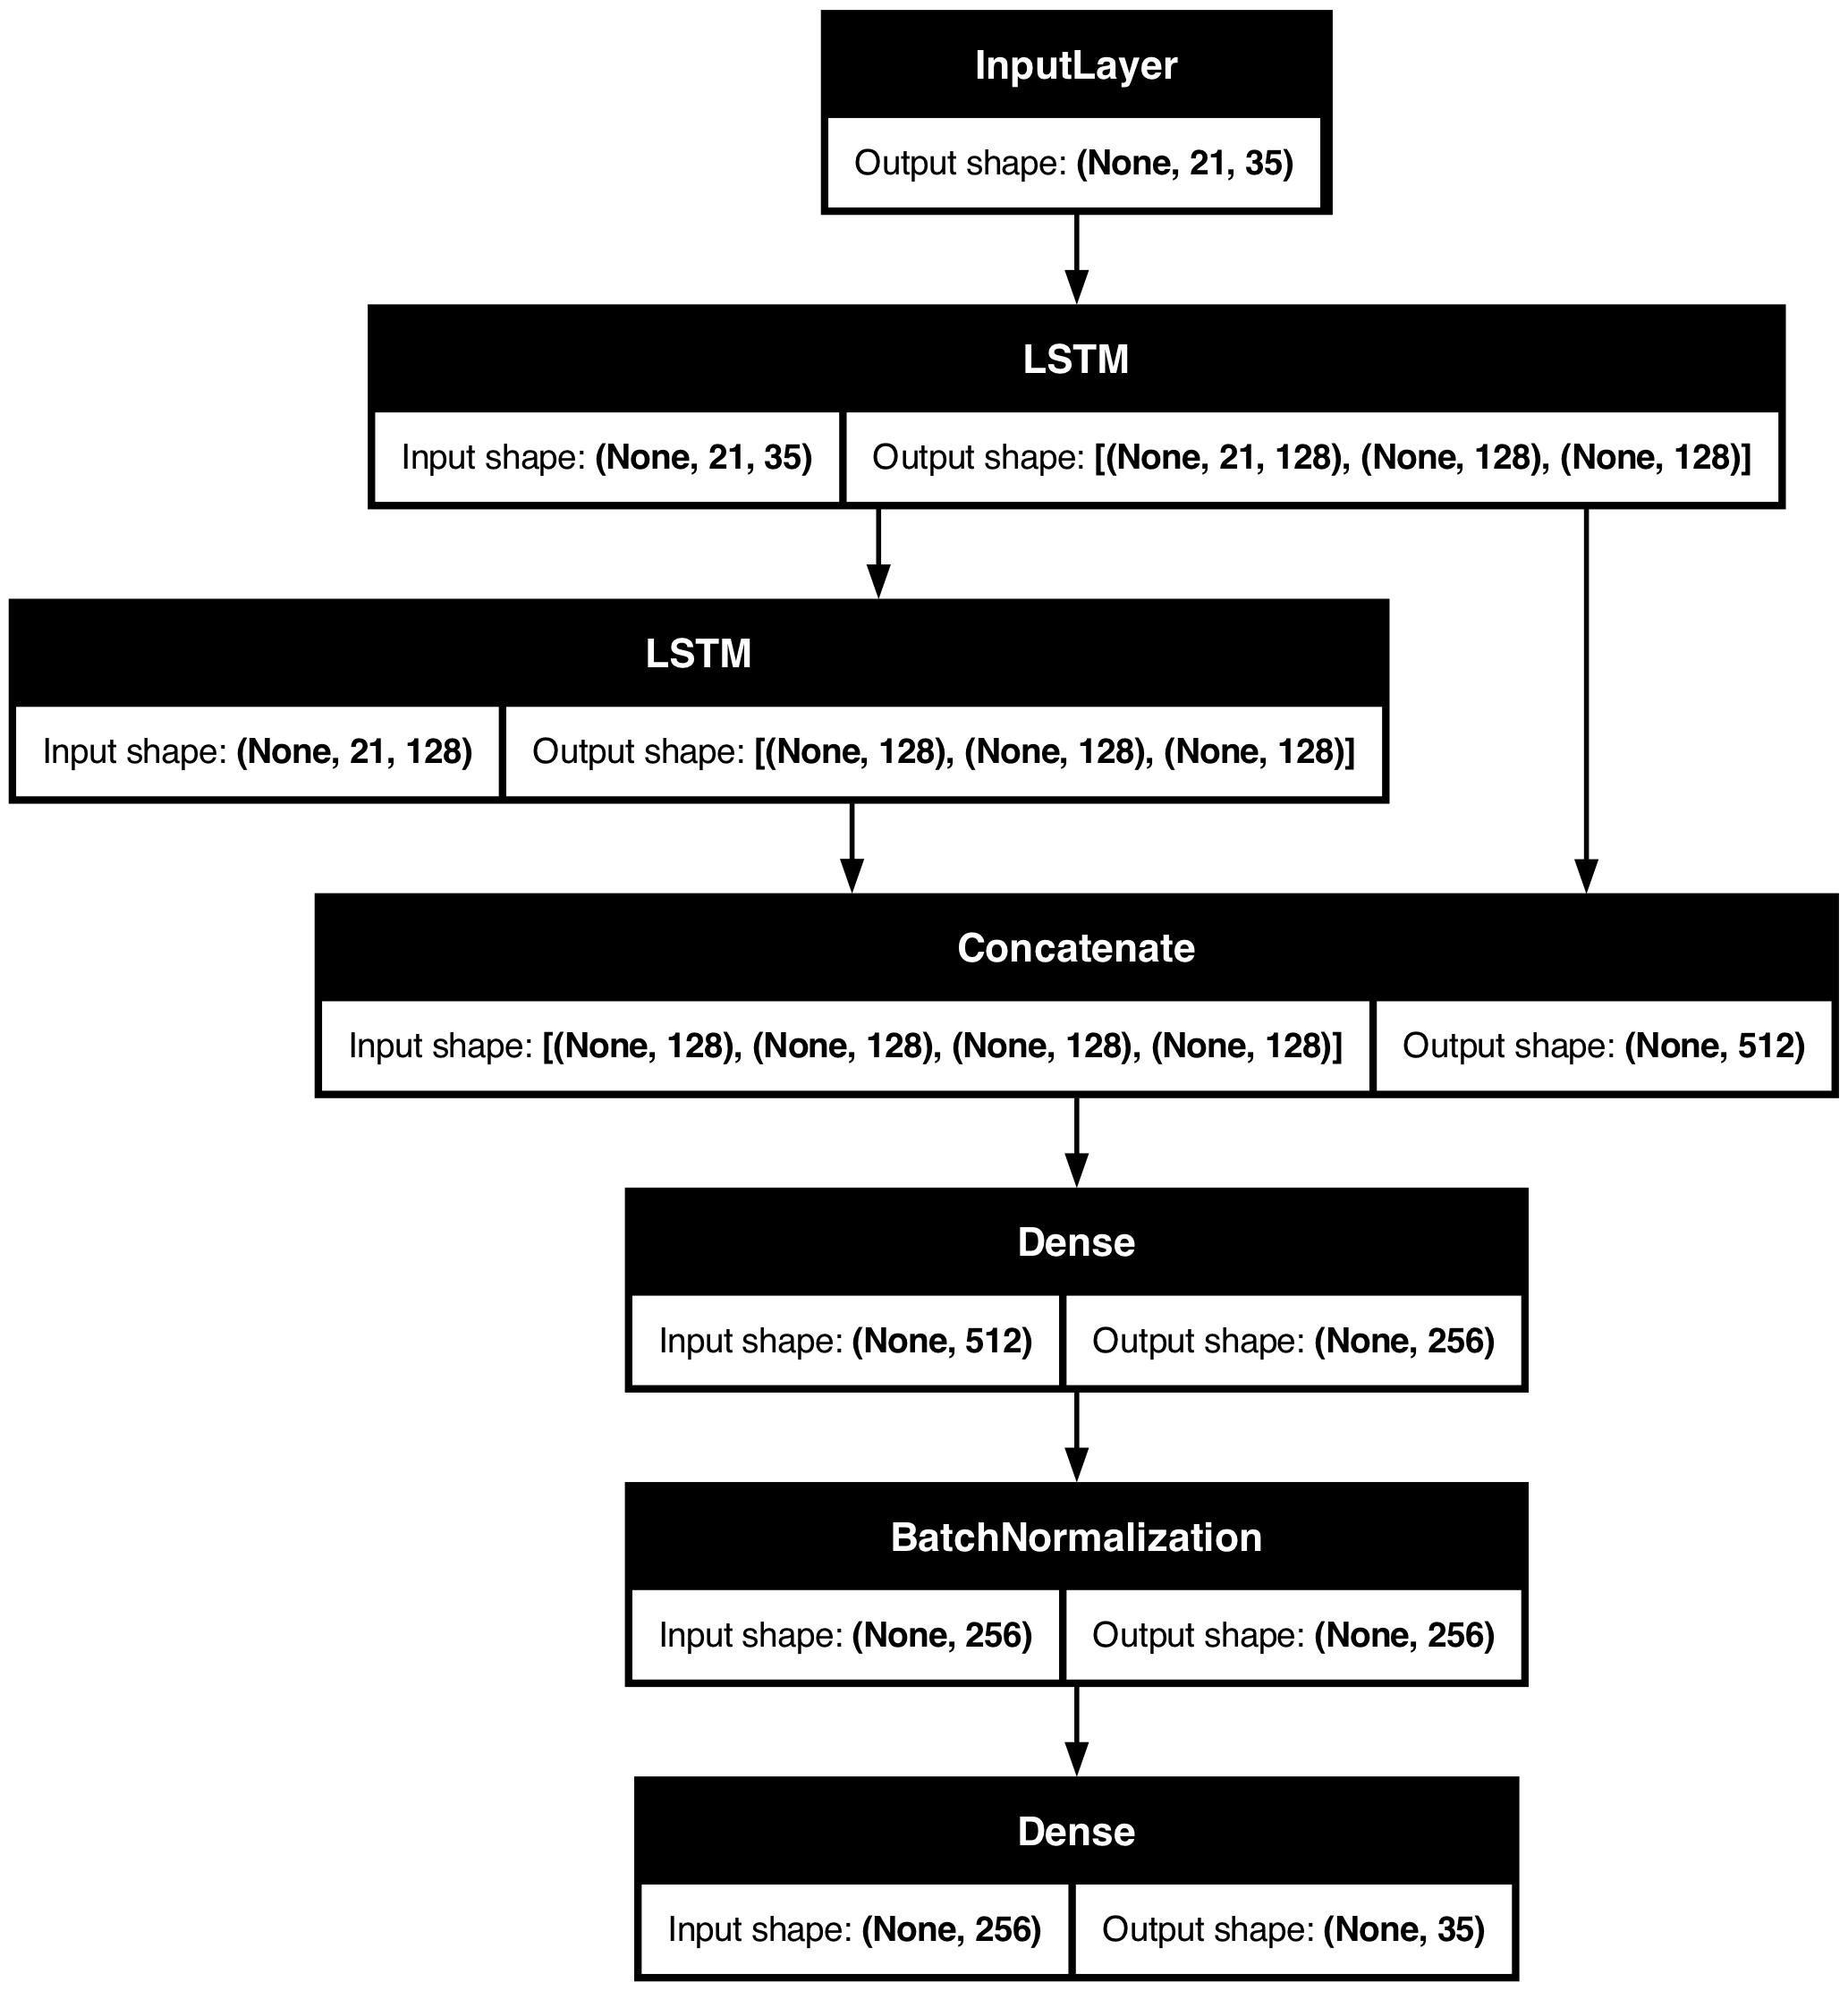

In [144]:
tf.keras.utils.plot_model(model=model,
         show_shapes=True, to_file='./enc-dec.png')

# Alternative Model Architectures

## Architecture 1

In [ ]:
# # Encoder

# encoder_inputs = Input((NUM_PLAYS, NUM_FEATURES))
# encoder_inputs = BatchNormalization()(encoder_inputs)

# # In a perfect world, Masking would be used. However, the mask was unable to be propogated through this network. 
# # In order to account for this, data was padded with 0s instead of -1.1 and masking was not applied.
# # See preprocess_data_enc-dec.ipynb for details.

# # encoder_inputs = Masking(mask_value=MASK_VAL)(encoder_inputs)

# encoder_lstm1 = LSTM(HIDDEN_SIZE, return_state=True, return_sequences=True)
# encoder_outputs1, state_h1, _ = encoder_lstm1(encoder_inputs)

# # LSTM Outputs are as follows: 
# # whole_seq_output, final_memory_state, final_carry_state


# encoder_lstm2 = LSTM(HIDDEN_SIZE, return_state=True, return_sequences=False) 
# _, state_h2, _ = encoder_lstm2(encoder_outputs1)

# # Decoder

# decoder_dense1 = Dense(HIDDEN_SIZE*2, activation="relu")(state_h1)
# decoder_dense2 = Dense(HIDDEN_SIZE*2, activation="relu")(state_h2)
# decoder_dense = Concatenate()([decoder_dense1, decoder_dense2])
# decoder_dense = Dense(HIDDEN_SIZE*2, activation="relu")(decoder_dense)



# decoder_outputs = Dense(NUM_FEATURES, activation="linear")(decoder_dense)


# model = Model(encoder_inputs, decoder_outputs)


## Architecture 2:

In [ ]:
# # Encoder

# encoder_inputs = Input((NUM_PLAYS, NUM_FEATURES))
# encoder_inputs = BatchNormalization()(encoder_inputs)

# # In a perfect world, Masking would be used. However, the mask was unable to be propogated through this network. 
# # In order to account for this, data was padded with 0s instead of -1.1 and masking was not applied.
# # See preprocess_data_enc-dec.ipynb for details.

# # encoder_inputs = Masking(mask_value=MASK_VAL)(encoder_inputs)

# encoder_lstm1 = LSTM(HIDDEN_SIZE, return_state=True, return_sequences=True)
# encoder_outputs1, state_h1, _ = encoder_lstm1(encoder_inputs)

# # LSTM Outputs are as follows: 
# # whole_seq_output, final_memory_state, final_carry_state


# encoder_lstm2 = LSTM(HIDDEN_SIZE, return_state=True, return_sequences=False) 
# _, state_h2, _ = encoder_lstm2(encoder_outputs1)

# # Decoder
# # Deep network

# decoder_dense = Dense(32, activation="relu", kernel_regularizer="l2")(state_h2)
# decoder_dense = Dense(32, activation="relu", kernel_regularizer="l2")(decoder_dense)
# decoder_dense = Dense(32, activation="relu", kernel_regularizer="l2")(decoder_dense)
# decoder_dense = Dense(32, activation="relu", kernel_regularizer="l2")(decoder_dense)


# # Base model

# # decoder_dense = Dense(HIDDEN_SIZE*2, activation="relu", kernel_regularizer="l2")(state_h2)



# decoder_outputs = Dense(NUM_FEATURES, activation="linear")(decoder_dense)


# model = Model(encoder_inputs, decoder_outputs)


## Architecture 3:

In [ ]:
# # Encoder

# encoder_inputs = Input((NUM_PLAYS, NUM_FEATURES))
# encoder_inputs = BatchNormalization()(encoder_inputs)

# # In a perfect world, Masking would be used. However, the mask was unable to be propogated through this network. 
# # In order to account for this, data was padded with 0s instead of -1.1 and masking was not applied.
# # See preprocess_data_enc-dec.ipynb for details.

# # encoder_inputs = Masking(mask_value=MASK_VAL)(encoder_inputs)

# encoder_lstm1 = LSTM(HIDDEN_SIZE, return_state=True, return_sequences=True)
# encoder_outputs1, state_h1, _ = encoder_lstm1(encoder_inputs)

# # LSTM Outputs are as follows: 
# # whole_seq_output, final_memory_state, final_carry_state


# encoder_lstm2 = LSTM(HIDDEN_SIZE, return_state=True, return_sequences=False) 
# _, state_h2, _ = encoder_lstm2(encoder_outputs1)

# # Decoder

# decoder_dense = Dense(HIDDEN_SIZE*2, activation="relu", kernel_regularizer="l2")(state_h2)

# decoder_outputs = Dense(NUM_FEATURES, activation="linear")(decoder_dense)


# model = Model(encoder_inputs, decoder_outputs)


# Old Code

In [ ]:
# decoder_inputs_train.shape, decoder_inputs_test.shape

In [ ]:
# x_train, x_test, decoder_inputs_train, decoder_inputs_test, y_train, y_test = train_test_split(x, decoder_inputs, y, test_size=0.2, random_state=1819)

## Model Creation Attempt 1

This seemed to fail because of the autoregressive nature of the problem. Will attempt again implementing more of an autoregressive model.

### Encoder

In [ ]:
# encoder_inputs = Input((NUM_PLAYS, NUM_FEATURES))
# encoder_inputs = Masking(mask_value=MASK_VAL)(encoder_inputs)
# encoder_inputs = BatchNormalization()(encoder_inputs)

# encoder_lstm1 = LSTM(hidden_size, return_state=True, return_sequences=True)
# encoder_outputs1, state_h1, state_c1 = encoder_lstm1(encoder_inputs)
# encoder_states = [state_h1, state_c1]

# encoder_lstm2 = LSTM(hidden_size, return_state=True, return_sequences=False) 
# encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_outputs1)
# encoder_states = [state_h2, state_c2]

### Decoder

In [ ]:
# decoder_inputs = Input((NUM_PLAYS, NUM_FEATURES))
# decoder_inputs = BatchNormalization()(decoder_inputs)

# # # Deprecated
# # # No need for LSTM in decoder since only trying to predict a single vector
# decoder_inputs = Masking(mask_value=MASK_VAL)(decoder_inputs)       # TODO: Mask before normalize
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True)
# decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# decoder_dense = Dense(NUM_FEATURES, activation="linear")
# decoder_outputs = decoder_dense(decoder_inputs)


In [ ]:
# print(f"Encoder mask: {encoder_inputs._keras_mask}")

### Full Model

In [ ]:
# model1 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Model Attempt 2

Here, we will be implementing an autoregressive model. Essentially, its an encoder-decoder without the LSTM in the decoder. The back half of the network is a fully-connected layer which can take the latent space encoding and produce a vector of shape (35,).

In [ ]:
# model2 = Sequential([
#     Input((NUM_PLAYS, NUM_FEATURES)),
#     Masking(mask_value=MASK_VAL),
#     BatchNormalization(),
#     LSTM(hidden_size, return_sequences=True, return_state=False),
#     LSTM(hidden_size, return_sequences=False, return_state=False),
#     Dense(hidden_size, activation="relu", kernel_regularizer="l2"),
#     Dense(NUM_FEATURES, activation="linear")
# ])

# Model Attempt 3

In [ ]:
# # Encoder

# encoder_inputs = Input((NUM_PLAYS, NUM_FEATURES))
# encoder_inputs = Masking(mask_value=-1.1, )(encoder_inputs)
# # encoder_inputs = BatchNormalization()(encoder_inputs)

# encoder_lstm1 = LSTM(hidden_size, return_state=True, return_sequences=True)
# encoder_outputs1, _, _ = encoder_lstm1(encoder_inputs, mask=encoder_inputs._keras_mask)
# # encoder_states = [state_h1, state_c1]

# encoder_lstm2 = LSTM(hidden_size, return_state=True, return_sequences=False) 
# _, state_h2, _ = encoder_lstm2(encoder_outputs1, mask=encoder_outputs1._keras_mask)
# # encoder_states = [state_h2, state_c2]

# # Decoder
# decoder_inputs = Input((NUM_FEATURES,))
# # decoder_inputs = Masking(mask_value=MASK_VAL)(decoder_inputs) 
# decoder_inputs = BatchNormalization()(decoder_inputs) 

# # Deprecated
# # # No need for LSTM in decoder since only trying to predict a single vector
#       # TODO: Mask before normalize
# # decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True)
# # decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# # decoder_dense = Dense(NUM_FEATURES, activation="linear")
# # decoder_outputs = decoder_dense(decoder_inputs)

# decoder_dense = Dense(hidden_size, activation="relu")(state_h2)  # Use final hidden state
# decoder_outputs = Dense(NUM_FEATURES, activation="linear")(decoder_dense)

# model3 = Model(encoder_inputs, decoder_outputs)

In [ ]:
# For attempt 1
# history = model1.fit([x_train, decoder_inputs_train], y_train,
#                     epochs=EPOCHS, batch_size=BATCH_SIZE,
#                     validation_data=([x_test, decoder_inputs_train], y_test))


# For attempt 3
# history = model3.fit([x_train, y_train], y_train,
#                     epochs=EPOCHS, batch_size=BATCH_SIZE,
#                     validation_data=([x_test, y_test], y_test))